# EDA for Titanic dataset
Nadav Elaykim

In this notebook I will present EDA for Titanic [Titanic dataset](https://www.kaggle.com/datasets/yasserh/titanic-dataset) and create a classifier to predict who will survive and who will not.\
The model need to be **explainable**, and highlight the more **informative features**.

1. **The first part** - Imports & Installations & confige
2. **The second part - EDA** 
    * Load and clean the data set
    * Analyzing the features and their relationships
    * Features engineering
3. **The third part -** 
    * Applying the Random Forest model
    * Applying the Random Forest model after finding the best parameter
    * Applying Logistic Regression model which developed from scratch

## Imports & Installations & confige

Installations

In [7]:
%%capture
!pip install -r requirements.txt


Imports

In [2]:
import os
import warnings
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.evaluation import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


configuration

In [3]:
sns.set()
%matplotlib inline
warnings.filterwarnings('ignore') 
%load_ext autoreload
%autoreload 2

plot configuration

In [4]:
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16


## EDA - Titanic dataset

### Load and overview Data

In [5]:
titanic_ds  = pd.read_csv('./data/Titanic-Dataset.csv')
titanic_ds.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
titanic_ds.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Handling null values:

In [8]:
print("Null values for each column:")
titanic_ds.isna().sum().sort_values(ascending=False)

Null values for each column:


Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

'Cabin' feature has a lot of Null values - drop it:

In [9]:
titanic_ds.drop('Cabin' , inplace = True ,axis=1)

Handling missing values in 'Age' by imputing the mean

In [10]:
titanic_ds['Age'].fillna(titanic_ds['Age'].mean(),inplace=True)


Handling 2 missing values in 'Embarked' by imputing the mode

In [11]:
titanic_ds["Embarked"].fillna(titanic_ds["Embarked"].mode()[0], inplace=True)

Check for no more Nulls

In [12]:
titanic_ds.isna().sum().sort_values(ascending=False)

Embarked       0
Fare           0
Ticket         0
Parch          0
SibSp          0
Age            0
Sex            0
Name           0
Pclass         0
Survived       0
PassengerId    0
dtype: int64

### Explore classes

In [13]:
titanic_ds['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

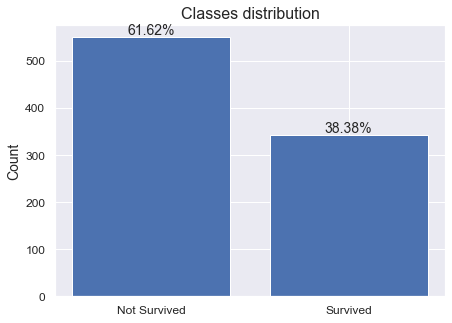

In [14]:
y_labels =  titanic_ds['Survived'].value_counts().tolist()

# Plot bar-chart
bars = plt.bar(['Not Survived', 'Survived'], y_labels)

# Plot the percentage of each class on top the bar chart 
plt.bar_label(bars, labels=[f'{100*c/sum(y_labels):.2f}%' for c in y_labels], fontsize = 14)

# Add titles
plt.title('Classes distribution')
plt.ylabel('Count')

plt.show()

The data isn't balanced - about two-thirds of the samples are taken from the "Not Survived" class.
However, the imbalance is not extreme.

### Features analysis

#### Categorical features
For categorical features  - analyzing the distribution of the different categories in relation to the different classes

**Pclass** - Ticket class

In [15]:
titanic_ds['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


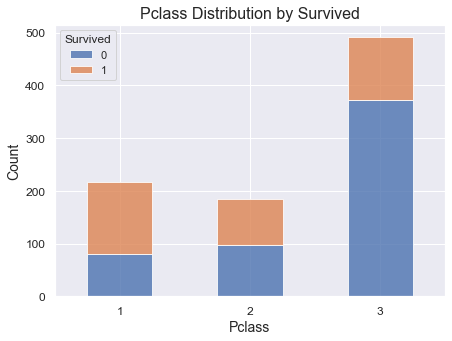

In [16]:
# Create a summary table - feature-class
table_pclass = titanic_ds.groupby(['Pclass', 'Survived']).size().unstack(fill_value=0)
print(table_pclass)

# Plot
table_pclass.plot(kind='bar', stacked=True, alpha = 0.8, rot = 0)

# Add titles
plt.title('Pclass Distribution by Survived')
plt.ylabel('Count')
plt.xlabel('Pclass')

plt.show()


* Class 3 had the highest number of passengers, and majority didn't survive, similar to the second class.
* In contrast, a significant majority of first-class passengers survived.

**Sex**

Survived    0    1
Sex               
female     81  233
male      468  109


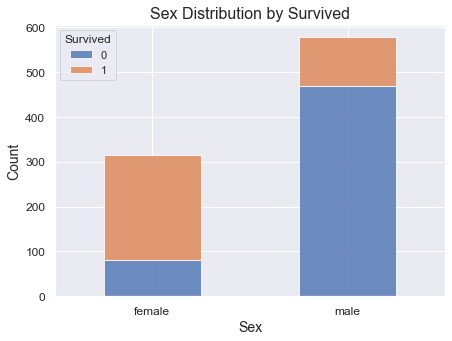

In [17]:
# Create a summary table - feature-class
table_sex = titanic_ds.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)
print(table_sex)

# Plot
table_sex.plot(kind='bar', stacked=True, alpha = 0.8, rot = 0)

# Add titles
plt.title('Sex Distribution by Survived')
plt.ylabel('Count')
plt.xlabel('Sex')

plt.show()

* The majority of passengers were male, nearly double the number of women.\
* Most of the mens did not survive.\
* Conversely, most women survived.

**Embarked** - Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampto

Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219


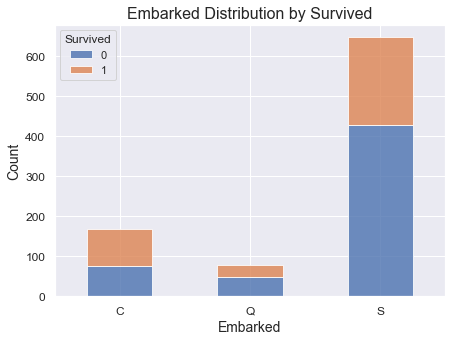

In [18]:
# Create a summary table - feature-class
table_embarked = titanic_ds.groupby(['Embarked', 'Survived']).size().unstack(fill_value=0)
print(table_embarked)

# Plot
table_embarked.plot(kind='bar', stacked=True, alpha = 0.8, rot = 0)

# Add titles
plt.title('Embarked Distribution by Survived')
plt.ylabel('Count')
plt.xlabel('Embarked')

plt.show()

* The majority of passengers embarked from Southampton.\
* In both Southampton and Queenstown most passengers didn't survived.
* However, most of passengers who boarded from Cherbourg survived.

#### Numrical features 

In the case of numerical features - plot the distribution in a histogram by class alongside a boxplot

**Age**

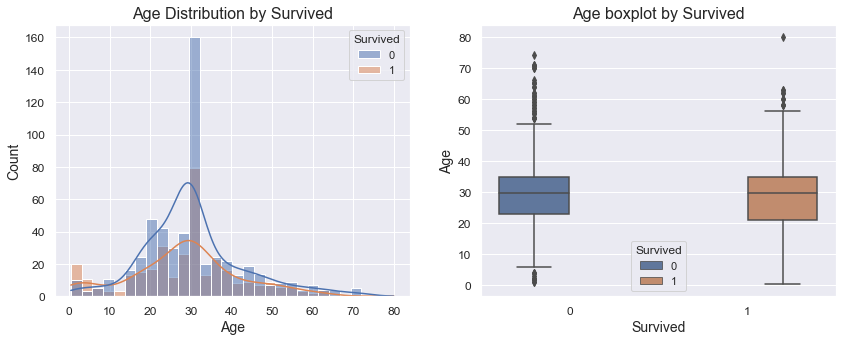

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))

# Plot histogram
sns.histplot(x='Age',hue='Survived',data=titanic_ds,kde=True, ax = ax1)
# Add titles
ax1.set_title('Age Distribution by Survived')

# Plot boxplot
sns.boxplot(x='Survived',y='Age',data=titanic_ds,ax = ax2, hue='Survived', saturation=0.6)
# Add titles
ax2.set_title('Age boxplot by Survived')

plt.show()

* Age spans from 0 to 80, averaging around 25.
* Survival rates favor the very young, reverse in the middle ages (20-40), and narrow as individuals get older.

**SibSp** - Nober of  aboard the Titanic

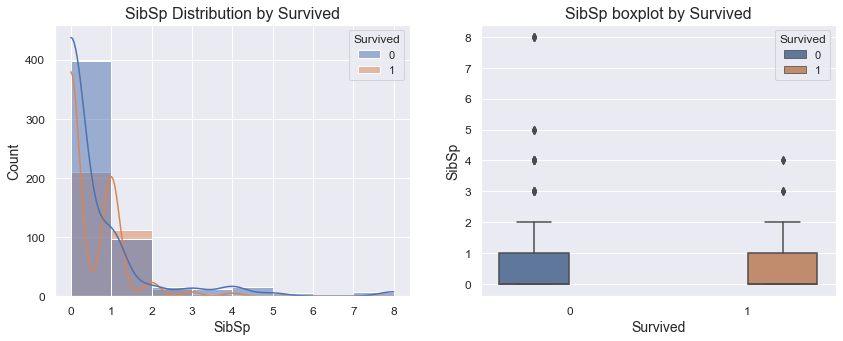

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))

# Plot histogram
sns.histplot(x='SibSp',hue='Survived',data=titanic_ds, kde=True, bins = 8, ax = ax1)
# Add titles
ax1.set_title('SibSp Distribution by Survived')

# Plot boxplot
sns.boxplot(x='Survived',y='SibSp',data=titanic_ds,ax = ax2, hue='Survived', saturation=0.6)
# Add titles
ax2.set_title('SibSp boxplot by Survived')

plt.show()

* Most passengers traveled without siblings/spouses, and a significant majority of them did not survive.
* Passengers with one or more siblings/spouses had a higher survival rate.

**Parch** - number of parents / children aboard the Titanic

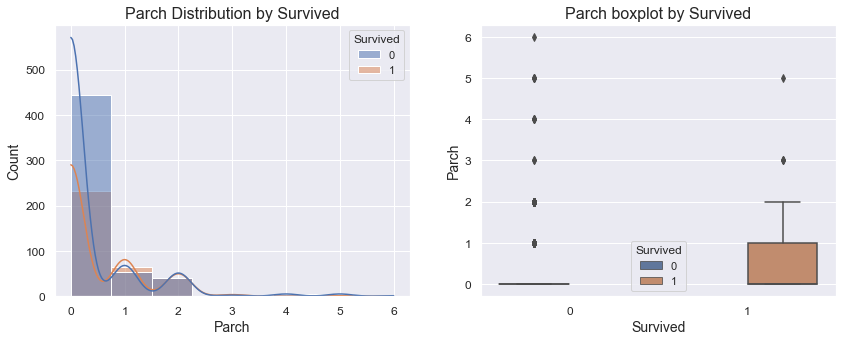

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))

# Plot histogram
sns.histplot(x='Parch',hue='Survived',data=titanic_ds, kde=True, bins = 8, ax = ax1)
# Add titles
ax1.set_title('Parch Distribution by Survived')

# Plot boxplot
sns.boxplot(x='Survived',y='Parch',data=titanic_ds,ax = ax2, hue='Survived', saturation=0.6)
# Add titles
ax2.set_title('Parch boxplot by Survived')

plt.show()

* The distribution is characteristically similar to SibSp.

**Fare** - Passenger fare

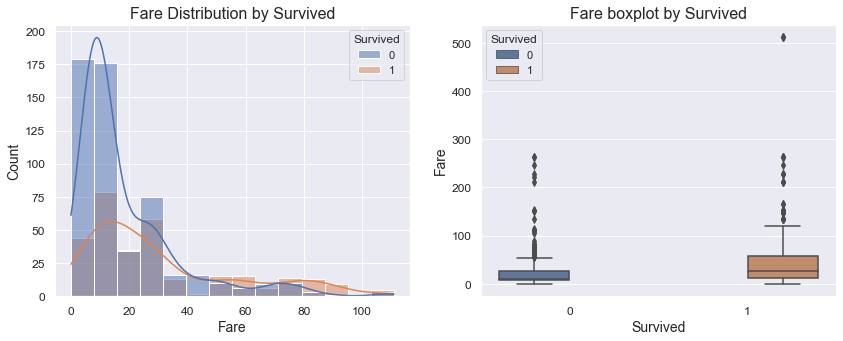

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))

# Plot histogram
# Limiti the histogram to the 95th percentile for a more convenient display
percentile_95 = titanic_ds['Fare'].quantile(0.95)
filtered_data = titanic_ds[titanic_ds['Fare'] <= percentile_95]
sns.histplot(x='Fare',hue='Survived',data=filtered_data, kde=True, bins = 14, ax = ax1)
# Add titles
ax1.set_title('Fare Distribution by Survived')

# Plot boxplot
sns.boxplot(x='Survived',y='Fare',data=titanic_ds,ax = ax2, hue='Survived', saturation=0.6)
# Add titles
ax2.set_title('Fare boxplot by Survived')

plt.show()

* Most of the passengers bought a ticket at low fares and most of them did not survive.
* Those who bought tickets at a higher rate survived more.

### Features Engineering

In [23]:
titanic_ds_engin = titanic_ds.copy(deep=True)

Drop non-category and non-numrical features

In [24]:
titanic_ds_engin.drop(['Name', 'Ticket', 'PassengerId'], axis = 1, inplace = True)

Handling categorical features

In [25]:
# Convert categorical variable into dummy/indicator variables.
Sex = pd.get_dummies(titanic_ds_engin['Sex'], drop_first=True)
Embarked = pd.get_dummies(titanic_ds_engin['Embarked'], drop_first=True)

# Drop old categorical columns
titanic_ds_engin.drop(['Sex', 'Embarked'], axis=1, inplace=True)

# add new dummy columns
titanic_ds_engin = pd.concat([titanic_ds_engin,Sex,Embarked], axis=1)

titanic_ds_engin.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Features correlation

Text(0.5, 1.0, 'Correlation matrix of all the features')

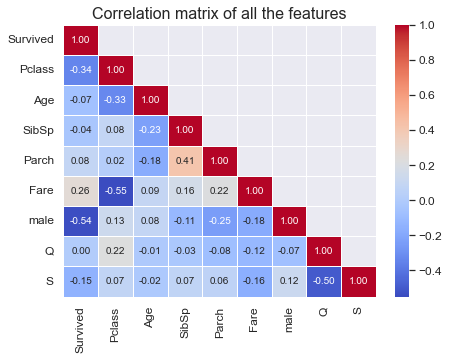

In [26]:
# Create correlation table
corr_matrix = titanic_ds_engin.corr()

# create mask for reset the upper right half of the  heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),1)
sns.heatmap(corr_matrix,
            annot=True,
            mask=mask,
            linewidths=.5,
            fmt=".2f",
            cmap='coolwarm')

plt.title("Correlation matrix of all the features")

* A moderate negative correlation can be seen between 'male' and 'Survived' and also between 'Fare' and 'Pclass'

## Models

### Split data train-test

In [27]:
# Utility for evaluation method and plots
from src.evaluation import *

In [28]:
from sklearn.model_selection import train_test_split

# Split to features and label
y = titanic_ds_engin['Survived'].copy(deep=True)
X = titanic_ds_engin.copy(deep=True)
X.drop(['Survived'], axis = 1, inplace=True)

# Split to train and test
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2)

data ={'X_train': X_train,
        'X_test': X_test,
        'y_train':y_train,
        'y_test': y_test}

# Print summrey
for key, val in data.items():
    print(f'{key} shape: {val.shape}')

X_train shape: (712, 8)
X_test shape: (179, 8)
y_train shape: (712,)
y_test shape: (179,)


In [29]:
# Initialize memory for the results of the different models
accuracy_mem = {}

###  Random Forest classifier - naive
The classification model is required to be explainable and to highlight the features that influenced the prediction.Models like Decision Trees or ensemble methods like Random Forests provide feature importance scores. These models can help you identify which features are more influential in making predictions.

In [30]:
# Create a Random Forest classifier
number_of_tree = 100
model_rf = RandomForestClassifier(n_estimators=number_of_tree, random_state=50)

# Train the model
_ = model_rf.fit(X_train, y_train)

In [31]:
# Make predictions on the test set
y_pred = model_rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_clac(y_test, y_pred)
conf_matrix_rf = confusion_matrix1(y_test, y_pred)
accuracy_mem["RandomForestClassifier"] = accuracy_rf

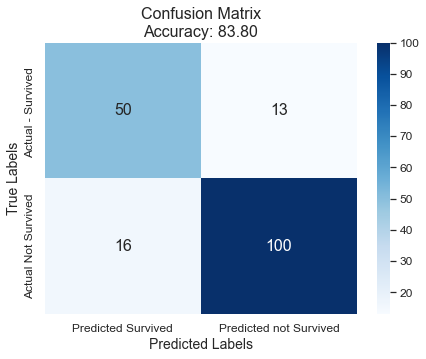

In [32]:
plot_result(conf_matrix_rf, accuracy_rf)

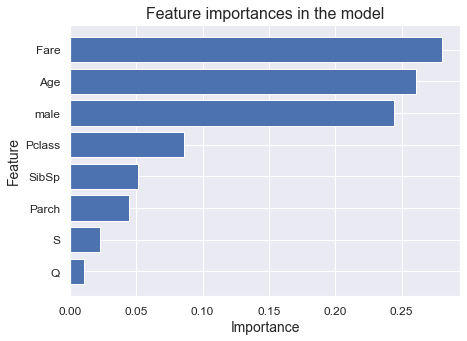

In [33]:
plot_importances(model_rf, X_train)

###  Random Forest classifier - with GridSearch


The Random Forest classifier model has many parameters that can be tuned. \
Find the parameters that lead to the best result using cross validation

In [34]:
param_rf_gs = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3,5,10,15],
    'min_samples_split': [3,6,10],
    'min_samples_leaf': [3,6,10],
    'criterion' : ['gini', 'entropy']  
}

model_rf_gs = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid=param_rf_gs,
                           cv=3,
                           verbose=1)

model_rf_gs.fit(X_train, y_train)
print("Best Parameters: ", model_rf_gs.best_params_)
best_rf_Model = model_rf_gs.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 50}


In [35]:
# Make predictions on the test set
y_pred = best_rf_Model.predict(X_test)

# Evaluate the model
accuracy_rf_gs = accuracy_clac(y_test, y_pred)
conf_matrix_rf_gs = confusion_matrix1(y_test, y_pred)
accuracy_mem["RandomForestGridSreach"] = accuracy_rf_gs

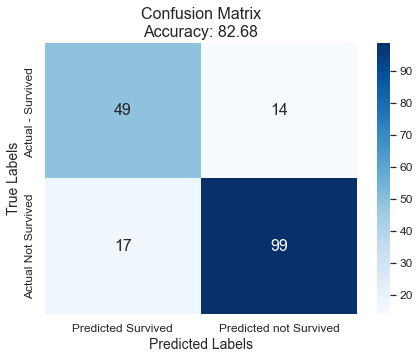

In [36]:
plot_result(conf_matrix_rf_gs, accuracy_rf_gs)

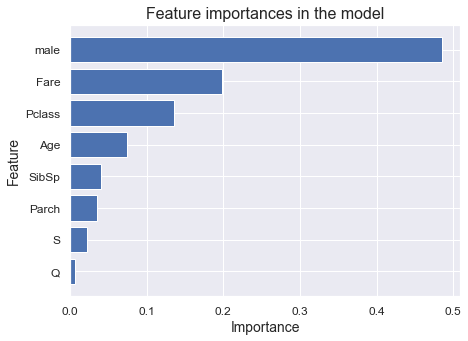

In [49]:
plot_importances(best_rf_Model, X_train)

### Logistic Regression

The purpose of using LogisticRegression is to show a simple example of building a model from scratch and using OOP

In [44]:
from src.model import LogisticRegression

model_lr = LogisticRegression(learning_rate=0.001,
                              n_iterations = 10000,
                              )
model_lr.fit(X_train, y_train)

In [45]:
# Make predictions on the test set
y_pred = model_lr.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_clac(y_test, y_pred)
conf_matrix_lr = confusion_matrix1(y_test, y_pred)
accuracy_mem["LogisticRegression"] = accuracy_lr

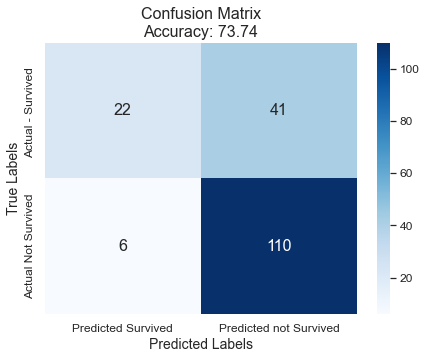

In [46]:
plot_result(conf_matrix_lr, accuracy_lr)

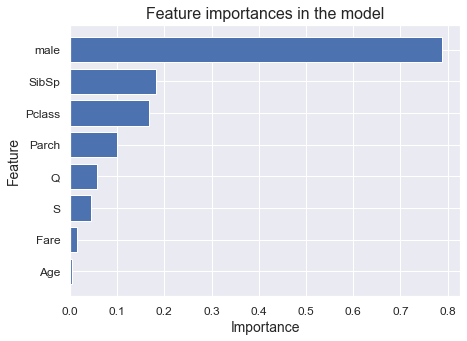

In [47]:
plot_importances(model_lr, X_train)

### Summary models's results

In [48]:
# Convert dict to DataFrame
df = pd.DataFrame(list(accuracy_mem.items()), columns=['Model', 'Accuracy'])

# Sort
df = df.sort_values(by='Accuracy', ascending=False)
df

,Model,Accuracy
0,RandomForestClassifier,83.798883
1,RandomForestGridSreach,82.681564
2,LogisticRegression,73.743017


To my understanding, the main purpose of the exercise is to assess my coding skills and handling of Exploratory Data Analysis (EDA):

1. I tried to be as original as possible and not rely on numerous examples available on the internet (even there are sophisticated things online).
2. I emphasized code quality - documentation, structure, indentation, etc.
3. I demonstrated the usage of modules.
4. I illustrated the use of popular data science libraries - numpy, pandas, matplotlib, sklearn.
5. I demonstrated the creation of a simple model from scratch while utilizing Object-Oriented Programming (OOP).

# Thanks!